# <center>**Tiendas Propias y Franquicias**</center>

Para el pronóstico de unidades para estos canales, se implementan los siguientes modelos:
<ul>
    <li>HOLT WINTERS</li>
    <li>ARIMA</li>
    <li>SARIMA</li>
    <li>XGBOOST</li>
    <li>PROPHET</li>
</ul>

De los cuales, el mejor desempeño lo presenta el modelo HOLT WINTERS.
El modelo es implementado 2 veces: la primera para pronosticar los meses de pandemia que corresponden al periodo de marzo-septiembre del 2020. La segunda implementación del modelo, se hace con los datos obtenidos del primer pronóstico.

### Liberías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import date, time, datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from hdbcli import dbapi as db

### Base de datos

In [2]:
# conn = db.connect(address='10.0.0.110', port='30015', user='DESARROLLO', password='DevHermeco.2022')
# cursor = conn.cursor()
# sql ='''SELECT "AÑO",
# "REGIÓN",
# "CANAL",
# "SOLICITANTE", 
# "MES",
# "SEMANA",
# "MATERIAL",
# "AFS: COLOR",
# "AFS: TALLA", 
# "UNIDADES", 
# "VALOR VENTA POS", 
# "Tipo de Negocio", 
# "Destino", 
# "Año de Venta", 
# "Mes de Venta", 
# "Sublínea",
# "Mundo",
# "Grupo de Artículo", 
# "Tipo de Artículo", 
# "Tipo de Tejido", 
# "Tipo de Referencia", 
# "Saldo", 
# "Clase", 
# "Concepto Diseño",
# "FECHA VENTA"
#         FROM HEP300.VW_CD_REPORTE_VENTAS_ALL_2016 \
#         WHERE "CANAL" IN ('TIENDAS PROPIAS', 'FRAQUICIAS')'''
# df_canal = pd.read_sql_query(sql, conn)

In [3]:
conn = db.connect(address='10.0.0.110', port='30015', user='DESARROLLO', password='DevHermeco.2022')
cursor = conn.cursor()
sql ='''SELECT "AÑO",
"REGIÓN",
"CANAL",
"SOLICITANTE", 
"MES",
"SEMANA",
"MATERIAL",
"AFS: COLOR",
"AFS: TALLA", 
"UNIDADES", 
"VALOR VENTA POS", 
"Tipo de Negocio", 
"Destino", 
"Año de Venta", 
"Mes de Venta", 
"Sublínea",
"Mundo",
"Grupo de Artículo", 
"Tipo de Artículo", 
"Tipo de Tejido", 
"Tipo de Referencia", 
"Saldo", 
"Clase", 
"Concepto Diseño",
"FECHA VENTA",
"Organización Ventas"
        FROM HEP300.VW_CD_REPORTE_VENTAS_ALL_2016 \
        WHERE ("Canal" = 'Tiendas Propias' OR "Canal" = 'Franquicias')
        AND "Organización Ventas" = 'Org.ventas Nacional'
'''
df_canal = pd.read_sql_query(sql, conn)

C:\Users\HELENAMM\AppData\Local\Temp\ipykernel_23132\4281423931.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_canal = pd.read_sql_query(sql, conn)


In [4]:
df_canal.isna().sum()

AÑO                    0
REGIÓN                 0
CANAL                  0
SOLICITANTE            0
MES                    0
SEMANA                 0
MATERIAL               0
AFS: COLOR             0
AFS: TALLA             0
UNIDADES               0
VALOR VENTA POS        0
Tipo de Negocio        0
Destino                0
Año de Venta           0
Mes de Venta           0
Sublínea               0
Mundo                  0
Grupo de Artículo      0
Tipo de Artículo       0
Tipo de Tejido         0
Tipo de Referencia     0
Saldo                  0
Clase                  0
Concepto Diseño        0
FECHA VENTA            0
Organización Ventas    0
dtype: int64

In [5]:
df_canal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7714782 entries, 0 to 7714781
Data columns (total 26 columns):
 #   Column               Dtype  
---  ------               -----  
 0   AÑO                  int64  
 1   REGIÓN               object 
 2   CANAL                object 
 3   SOLICITANTE          object 
 4   MES                  int64  
 5   SEMANA               int64  
 6   MATERIAL             object 
 7   AFS: COLOR           object 
 8   AFS: TALLA           object 
 9   UNIDADES             float64
 10  VALOR VENTA POS      float64
 11  Tipo de Negocio      object 
 12  Destino              object 
 13  Año de Venta         object 
 14  Mes de Venta         object 
 15  Sublínea             object 
 16  Mundo                object 
 17  Grupo de Artículo    object 
 18  Tipo de Artículo     object 
 19  Tipo de Tejido       object 
 20  Tipo de Referencia   object 
 21  Saldo                object 
 22  Clase                object 
 23  Concepto Diseño      object 
 24

In [6]:
df = df_canal.loc[(df_canal['Concepto Diseño'] == 'SPECIAL OCCASIONS')]
df['Fecha'] = pd.to_datetime(df_canal['FECHA VENTA'], format='%Y-%m-%d')

C:\Users\HELENAMM\AppData\Local\Temp\ipykernel_23132\984080206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha'] = pd.to_datetime(df_canal['FECHA VENTA'], format='%Y-%m-%d')


### PRUEBAS

In [7]:
# TIPO DE ARTICULO Y MUNDO
prueba1 = df.loc[df["Mundo"] == "PRIMI NIÑO"]
prueba1 = prueba1.loc[prueba1["Tipo de Artículo"] == 'SET']
prueba1 = prueba1.groupby('Fecha')['UNIDADES'].sum().resample(
                    'MS').sum().to_frame().reset_index().sort_values(by='Fecha')
prueba1

,Fecha,UNIDADES
0,2016-11-01,113.0
1,2016-12-01,123.0
2,2017-01-01,31.0
3,2017-02-01,14.0
4,2017-03-01,2.0


In [8]:
conn = db.connect(address='10.0.0.110', port='30015', user='DESARROLLO', password='DevHermeco.2022')
cursor = conn.cursor()
sql ='''SELECT "AÑO",
"REGIÓN",
"CANAL",
"SOLICITANTE", 
"MES",
"SEMANA",
"MATERIAL",
"AFS: COLOR",
"AFS: TALLA", 
"UNIDADES", 
"VALOR VENTA POS", 
"Tipo de Negocio", 
"Destino", 
"Año de Venta", 
"Mes de Venta", 
"Sublínea",
"Mundo",
"Grupo de Artículo", 
"Tipo de Artículo", 
"Tipo de Tejido", 
"Tipo de Referencia", 
"Saldo", 
"Clase", 
"Concepto Diseño",
"FECHA VENTA",
"Organización Ventas"
        FROM HEP300.VW_CD_REPORTE_VENTAS_ALL_2016 \
        WHERE "Tipo de Artículo" = 'SET'
        AND "Mundo" = 'PRIMI NIÑO'
        AND ("Canal" = 'Tiendas Propias' OR "Canal" = 'Franquicias')
        AND "Organización Ventas" = 'Org.ventas Nacional'

'''
df_prueba1 = pd.read_sql_query(sql, conn)

C:\Users\HELENAMM\AppData\Local\Temp\ipykernel_23132\4090112294.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_prueba1 = pd.read_sql_query(sql, conn)


In [9]:
df_prueba1['Fecha'] = pd.to_datetime(df_prueba1['FECHA VENTA'], format='%Y-%m-%d')
df_prueba1 = df_prueba1.loc[(df_prueba1['Concepto Diseño'] == 'SPECIAL OCCASIONS')&
                            (df_prueba1["Organización Ventas"] == 'Org.ventas Nacional')]

df_prueba1.groupby('Fecha')['UNIDADES'].sum().resample(
                    'MS').sum().to_frame().reset_index().sort_values(by='Fecha')

,Fecha,UNIDADES
0,2016-11-01,113.0
1,2016-12-01,123.0
2,2017-01-01,31.0
3,2017-02-01,14.0
4,2017-03-01,2.0


In [71]:
ex3 = df.loc[df['Sublínea'] == 'SPECIAL']
ex3['Concepto Diseño'].unique()

array(['SPECIAL OCCASIONS'], dtype=object)

### TABLA POSIBLES COMBINACIONES

In [10]:
input_data = {'MUNDO':[],
            'TIPO ARTICULO' :[],
            'TOTAL MONTHS': []
            }
clasificacion =  pd.DataFrame(input_data)

In [11]:
clasificacion

,MUNDO,TIPO ARTICULO,TOTAL MONTHS


In [12]:
for j in (df["Mundo"].unique().tolist()):
    for i in sorted(df["Tipo de Artículo"].unique().tolist()):
        
        data = df.loc[df["Tipo de Artículo"] == i]
        data = data.loc[(df["Mundo"] == j)]
        
        if((len(data) == 0) | (len(data) < 12)): # filtrar ventas con menos de 12 valores
            continue
        else:
            data2 = data.groupby('Fecha')['UNIDADES'].sum().resample(
                    'MS').sum().to_frame().reset_index().sort_values(by='Fecha')
            data2['months'] = data2['Fecha'].dt.month

            data2 = data2.loc[data2['UNIDADES'] != 0]
            
            if((len(data2['months']) < 60)): # cantidad de meses de venta
                continue
    
            else:
                new_row = {'MUNDO': j,
                        'TIPO ARTICULO': i,
                        'TOTAL MONTHS': len(data2),
                        'ENERO': data2['months'].value_counts()[:][1],
                        'FEBRERO':data2['months'].value_counts()[:][2],
                        'MARZO': data2['months'].value_counts()[:][3],
                        'ABRIL': data2['months'].value_counts()[:][4],
                        'MAYO': data2['months'].value_counts()[:][5],
                        'JUNIO': data2['months'].value_counts()[:][6],
                        'JULIO': data2['months'].value_counts()[:][7],
                        'AGOSTO': data2['months'].value_counts()[:][8],
                        'SEPTIEMBRE': data2['months'].value_counts()[:][9],
                        'OCTUBRE': data2['months'].value_counts()[:][10],
                        'NOVIEMBRE': data2['months'].value_counts()[:][11],
                        'DICIEMBRE': data2['months'].value_counts()[:][12]
                }
            
            clasificacion = clasificacion.append(new_row, ignore_index=True)

C:\Users\HELENAMM\AppData\Local\Temp\ipykernel_23132\1966782828.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clasificacion = clasificacion.append(new_row, ignore_index=True)
C:\Users\HELENAMM\AppData\Local\Temp\ipykernel_23132\1966782828.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clasificacion = clasificacion.append(new_row, ignore_index=True)
C:\Users\HELENAMM\AppData\Local\Temp\ipykernel_23132\1966782828.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clasificacion = clasificacion.append(new_row, ignore_index=True)
C:\Users\HELENAMM\AppData\Local\Temp\ipykernel_23132\1966782828.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [13]:
clasificacion.sort_values(by="TOTAL MONTHS")

,MUNDO,TIPO ARTICULO,TOTAL MONTHS,ENERO,FEBRERO,MARZO,ABRIL,MAYO,JUNIO,JULIO,AGOSTO,SEPTIEMBRE,OCTUBRE,NOVIEMBRE,DICIEMBRE
0,NIÑA,BALETA,61.0,6.0,6.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
15,PRIMI NIÑO,ZAPATOS COSIDOS,61.0,5.0,7.0,6.0,5.0,4.0,5.0,5.0,4.0,3.0,5.0,6.0,6.0
16,BEBÉ NIÑA,BALETA,62.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
28,NIÑO,CORREA,66.0,6.0,5.0,5.0,4.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
25,NIÑO,CAÑA LARGA,66.0,6.0,6.0,5.0,4.0,4.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0
5,PRIMI NIÑA,VESTIDO MANGA CORTA,66.0,6.0,6.0,7.0,5.0,4.0,5.0,6.0,6.0,5.0,6.0,5.0,5.0
10,BEBÉ NIÑO,CAÑA LARGA,67.0,5.0,7.0,6.0,5.0,6.0,6.0,7.0,5.0,5.0,5.0,5.0,5.0
19,BEBÉ NIÑA,MINIFALDA,67.0,6.0,6.0,6.0,5.0,4.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0
27,NIÑO,CORBATA,67.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,7.0,6.0
23,NIÑO,BERMUDA,68.0,6.0,6.0,6.0,4.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0


### prueba 2

In [14]:
fechas_completa = pd.DataFrame(pd.date_range(start='2016-01-01', end='2023-01-01',freq='MS'), columns=['Fecha'])

In [32]:
# TIPO DE ARTICULO Y MUNDO 
# prueba2 = df.loc[df["Mundo"] == "BEBÉ NIÑA"]
# prueba2 = prueba2.loc[prueba2["Tipo de Artículo"] == 'CAMISA MANGA SISA']
# prueba2 = prueba2.groupby('Fecha')['UNIDADES'].sum().resample(
#                     'MS').sum().to_frame().reset_index().sort_values(by='Fecha')

# #  PRIMI NIÑO / CHALECO
prueba2 = df.loc[df["Mundo"] == "PRIMI NIÑO"]
prueba2 = prueba2.loc[prueba2["Tipo de Artículo"] == 'CHALECO']
prueba2 = prueba2.groupby('Fecha')['UNIDADES'].sum().resample(
                    'MS').sum().to_frame().reset_index().sort_values(by='Fecha')

# prueba2[:48]

#  NIÑA / VESTIDO MANGA SISA
# prueba2 = df.loc[df["Mundo"] == "NIÑA"]
# prueba2 = prueba2.loc[prueba2["Tipo de Artículo"] == 'VESTIDO MANGA SISA']
# prueba2 = prueba2.groupby('Fecha')['UNIDADES'].sum().resample(
#                     'MS').sum().to_frame().reset_index().sort_values(by='Fecha')

# prueba2 = prueba2.loc[prueba2['UNIDADES'] != 0]
prueba2[:48]



,Fecha,UNIDADES
0,2016-02-01,1.0
1,2016-03-01,55.0
2,2016-04-01,50.0
3,2016-05-01,20.0
4,2016-06-01,9.0
5,2016-07-01,10.0
6,2016-08-01,0.0
7,2016-09-01,0.0
8,2016-10-01,0.0
9,2016-11-01,0.0


In [16]:
df_fill_0 = fechas_completa.merge(prueba2, on='Fecha',how='left').fillna(0)
df_fill_0

,Fecha,UNIDADES
0,2016-01-01,0.0
1,2016-02-01,1.0
2,2016-03-01,55.0
3,2016-04-01,50.0
4,2016-05-01,20.0
...,...,...
80,2022-09-01,4.0
81,2022-10-01,0.0
82,2022-11-01,0.0
83,2022-12-01,0.0


#### MODELO

In [17]:
from statsmodels.tsa.api import STLForecast, ExponentialSmoothing, ExponentialSmoothing

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

from statsmodels.tsa.api import STLForecast, ExponentialSmoothing, ETSModel

import warnings
warnings.filterwarnings('ignore')

In [18]:
y_train = prueba2.loc[prueba2['Fecha'] <= '2020-02-01'].set_index('Fecha')
y_test = prueba2.loc[(prueba2['Fecha'] >= '2020-03-01') & (prueba2['Fecha'] <= '2020-09-01')].set_index('Fecha')

# FILL NAN VALUES 
# y_train = df_fill_0.loc[df_fill_0['Fecha'] <= '2020-02-01'].set_index('Fecha')
# y_test = df_fill_0.loc[(df_fill_0['Fecha'] >= '2020-03-01') & (df_fill_0['Fecha'] <= '2020-09-01')].set_index('Fecha')


config_5 = {"seasonal_periods":12,
                #"trend":"add",
                "seasonal":"add",
                #"damped_trend":True,
                #"use_boxcox":True,
                #"initialization_method":"estimated"
                "initialization_method":'estimated'
    }

stlf_es_5 = STLForecast(y_train,
                        ExponentialSmoothing, 
                        model_kwargs = config_5, 
                        period=12, 
                        robust=True, seasonal_deg=0, trend_deg=0, low_pass_deg=0,
                        )

stlf_result = stlf_es_5.fit()
forecast_es = stlf_result.forecast(len(y_test))
y_test["STL_HOLT WINTER (ADD SEASONAL)"] = forecast_es.values
forecast_es.index = y_test.index

In [19]:
y_test

,UNIDADES,STL_HOLT WINTER (ADD SEASONAL)
Fecha,,
2020-03-01,1.0,58.544378
2020-04-01,0.0,49.903011
2020-05-01,0.0,50.513558
2020-06-01,0.0,42.625692
2020-07-01,0.0,23.488993
2020-08-01,0.0,21.088168
2020-09-01,0.0,23.912355


In [20]:
y_train_sintetico = prueba2.loc[prueba2['Fecha'] <= '2020-02-01'].set_index('Fecha').append(
    [y_test.drop(columns=['UNIDADES'],axis=1).rename(columns={'STL_HOLT WINTER (ADD SEASONAL)':'UNIDADES'}),
    prueba2.loc[(prueba2['Fecha'] >='2020-10-01') & (prueba2['Fecha'] <='2022-12-01')].set_index('Fecha')
    ]
)

# FILLING WITH 0
# y_train_sintetico = df_fill_0.loc[df_fill_0['Fecha'] <= '2020-02-01'].set_index('Fecha').append(
#     [y_test.drop(columns=['UNIDADES'],axis=1).rename(columns={'STL_HOLT WINTER (ADD SEASONAL)':'UNIDADES'}),
#     df_fill_0.loc[(df_fill_0['Fecha'] >='2020-10-01') & (df_fill_0['Fecha'] <='2023-01-01')].set_index('Fecha')
#     ]
# )

In [21]:
config_5_sintetico = {"seasonal_periods":12,
                        #"trend":"add",
                        "seasonal":"add",
                        #"damped_trend":True,
                        #"use_boxcox":True,
                        #"initialization_method":"estimated"
                        "initialization_method":"estimated"}

stlf_es_5_sintetico = STLForecast(y_train_sintetico, 
                                ExponentialSmoothing, 
                                model_kwargs = config_5_sintetico,
                                period=12, 
                                robust=True, seasonal_deg=0, trend_deg=0, low_pass_deg=0)

stlf_res_es_5_sintetico = stlf_es_5_sintetico.fit()
forecast_es_5_sintetico = stlf_res_es_5_sintetico.forecast(36)
y_test_5_sintetico = forecast_es_5_sintetico.values

In [22]:
forecast_es_5_sintetico.to_frame().reset_index()

,index,0
0,2022-10-01,1.615250
1,2022-11-01,10.027626
2,2022-12-01,14.139766
3,2023-01-01,-0.985145
4,2023-02-01,-0.895873
5,2023-03-01,27.578007
6,2023-04-01,24.094524
7,2023-05-01,26.792055
8,2023-06-01,20.705725
9,2023-07-01,6.584746


<AxesSubplot: xlabel='Fecha'>

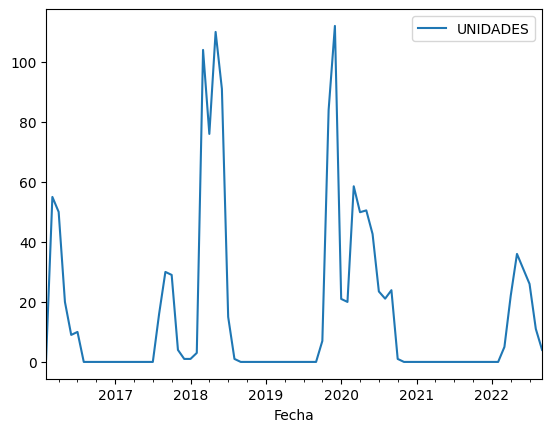

In [23]:
y_train_sintetico.plot()

<AxesSubplot: >

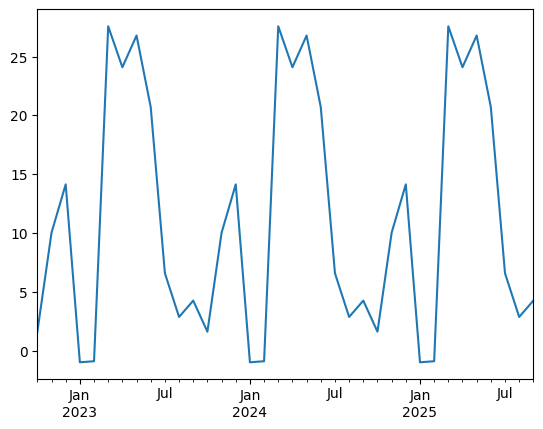

In [24]:
forecast_es_5_sintetico.plot()

#### PROPHET

In [25]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

In [26]:
dfProphet = prueba2.rename(columns={'Fecha': 'ds', 'UNIDADES': 'y'})
dfProphet = dfProphet.loc[dfProphet['ds'] <= '2022-12-01']

dfProphet['covid'] = [1 if ((x > pd.Timestamp(
    '2020-03-01')) & (x < pd.Timestamp('2021-03-01'))) else 0 for x in dfProphet['ds']]

In [27]:
train_covid = dfProphet.loc[dfProphet.ds <= '2021-10-01']

# MODELO
m = Prophet()

# add a regressor to the model to account for the effects of COVID-19
m.add_regressor('covid')

m.fit(train_covid)

08:28:20 - cmdstanpy - INFO - Chain [1] start processing
08:28:21 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = m.make_future_dataframe(periods=16, freq='MS')
future['covid'] = 0

# make the forecast
forecast = m.predict(future)

# plot the forecast
# m.plot(forecast)

In [29]:
forecast[['ds','yhat']]

,ds,yhat
0,2016-02-01,0.000710
1,2016-03-01,34.452425
2,2016-04-01,30.616488
3,2016-05-01,17.597231
4,2016-06-01,11.987387
...,...,...
80,2022-10-01,-4.562917
81,2022-11-01,21.578405
82,2022-12-01,32.147502
83,2023-01-01,-4.537860


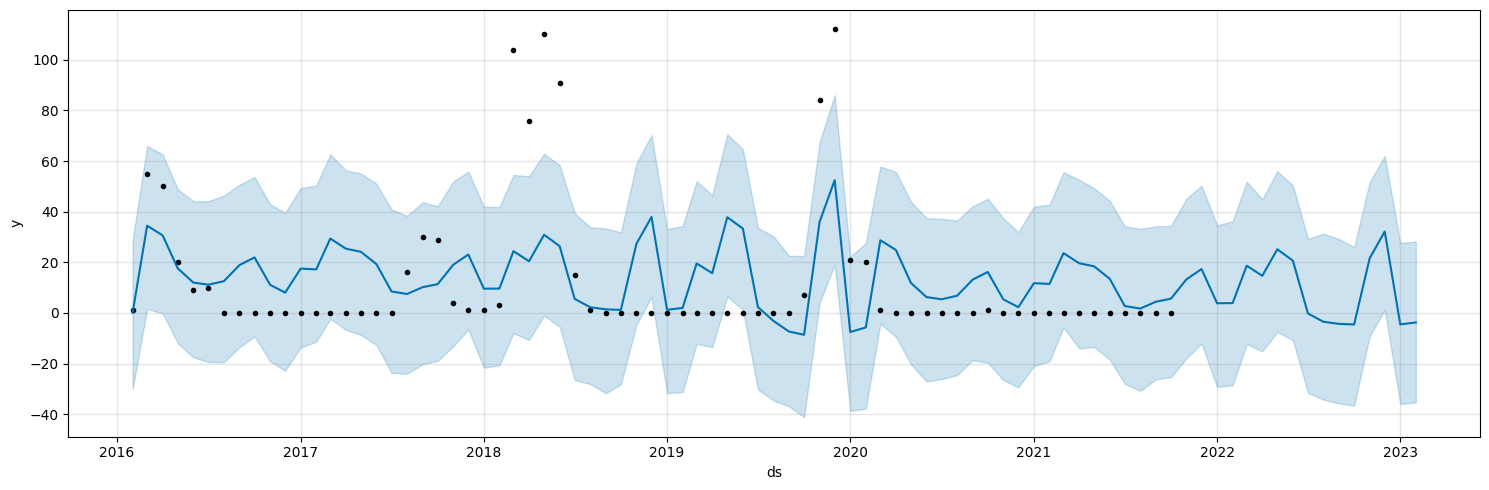

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# ax.scatter(forecast.ds, forecast['y'], color='r')
fig = m.plot(forecast, ax=ax)

### PRUEBA 3

In [34]:
df['Año de Venta'].unique()

array(['2019', '2018', '2022', '2017', '2016', '2020', '2021', '2023',
       '2015', '2014', '2013', '2012', '2010'], dtype=object)

In [35]:
df['Mes de Venta'].unique()

array(['NOVIEMBRE', 'JULIO', 'MARZO', 'SEPTIEMBRE', 'ABRIL', 'MAYO',
       'OCTUBRE', 'AGOSTO', 'FEBRERO', 'DICIEMBRE', 'JUNIO'], dtype=object)

In [67]:
ex = df.loc[df["Mundo"] == "NIÑO"]
ex1 = ex.loc[ex["Tipo de Artículo"] == 'CAMISA MANGA CORTA']
ex = ex1.groupby(['Año de Venta','Mes de Venta','MES','AÑO'])['UNIDADES'].sum().to_frame().reset_index()
ex = ex.loc[(ex['Mes de Venta'] == 'NOVIEMBRE') | (ex['Mes de Venta'] == 'OCTUBRE') | (ex['Mes de Venta'] == 'SEPTIEMBRE')]
ex.loc[ex['MES'] == 11]

,Año de Venta,Mes de Venta,MES,AÑO,UNIDADES
10,2019,NOVIEMBRE,11,2019,292.0
26,2020,NOVIEMBRE,11,2020,327.0
40,2021,OCTUBRE,11,2021,620.0
56,2022,SEPTIEMBRE,11,2022,86.0


## Holt Winters

In [ ]:
from statsmodels.tsa.api import STLForecast, ExponentialSmoothing, ExponentialSmoothing

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

from statsmodels.tsa.api import STLForecast, ExponentialSmoothing, ETSModel

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Agrupar la base de datos por mensual
df_model = df.groupby('Fecha')['UNIDADES'].sum().resample(
    'MS').sum().to_frame().reset_index().sort_values(by='Fecha')

In [ ]:
def modelo_2023(data,tipo,mundo):
    
    df_time_series_5 = data[["Fecha", "UNIDADES"]].groupby("MES_AÑO").sum()[["UNIDADES"]]
    
    y_train_5 = df_time_series_5.head(50)
    y_test_5 = df_time_series_5.iloc[50:83]

    config_5 = {"seasonal_periods":12,
                #"trend":"add",
                "seasonal":"add",
                #"damped_trend":True,
                #"use_boxcox":True,
                #"initialization_method":"estimated"
                "initialization_method":'estimated'
    }

    stlf_es_5 = STLForecast(y_train_5,
                            ExponentialSmoothing, \
                            model_kwargs = config_5, 
                            period=12, 
                            robust=True, seasonal_deg=0, trend_deg=0, low_pass_deg=0,
                            )

    stlf_res_es_5 = stlf_es_5.fit()
    forecast_es_5 = stlf_res_es_5.forecast(33)
    y_test_5["STL_HOLT WINTER (ADD SEASONAL)"] = forecast_es_5.values
    forecast_es_5.index = y_test_5.index

    # DATOS SINTETICOS
    y_train_5_sintetico = df_time_series_5.head(50)["UNIDADES"].append([forecast_es_5[:7], 
                                                                        df_time_series_5.iloc[57:84]["UNIDADES"]])

    config_5_sintetico = {"seasonal_periods":12,
                            #"trend":"add",
                            "seasonal":"add",
                            #"damped_trend":True,
                            #"use_boxcox":True,
                            #"initialization_method":"estimated"
                            "initialization_method":"estimated"}
    
    stlf_es_5_sintetico = STLForecast(y_train_5_sintetico, 
                                    ExponentialSmoothing, 
                                    model_kwargs = config_5_sintetico,
                                    period=12, 
                                    robust=True, seasonal_deg=0, trend_deg=0, low_pass_deg=0)

    stlf_res_es_5_sintetico = stlf_es_5_sintetico.fit()
    forecast_es_5_sintetico = stlf_res_es_5_sintetico.forecast(12)
    y_test_5_sintetico = forecast_es_5_sintetico.values

    # RESULTADOS EN DF    
    # Create DataFrame
    #df_final = pd.DataFrame(data2)

    return y_test_5_sintetico

### Datos sintéticos

In [ ]:
# Train :febreo 2020
train = df_model.loc[df_model.Fecha <='2020-02-01'].set_index('Fecha')
# Datos Test marxo sept 2020
test = df_model.loc[(df_model.Fecha >='2020-03-01')  & (df_model.Fecha <='2020-09-01')].set_index('Fecha')

In [ ]:
ES = ExponentialSmoothing
        
configES = {#'trend': 'add',
        'seasonal' :"add",
        #'damped_trend' : True,
        'seasonal_periods': 12,
        "initialization_method":"estimated"
        }

stlf = STLForecast(train, 
                    ES,
                    model_kwargs = configES,
                    period = 12,
                    robust = False,
                    seasonal_deg = 0, trend_deg = 0, low_pass_deg = 0
                    )

stlf_res = stlf.fit()
forecast = stlf_res.forecast(len(test))
test['forecast_sintetic_data'] = forecast


# METRICAS
y = test['UNIDADES']
y_predict = test['forecast_sintetic_data']

print('Modelo HOLT WINTERS + STLF Pronostico marzo-septiembre 2022')
print("R^2      ..............",  round(r2_score(y, y_predict),2))
print('RMSE ES   ..............',  round(math.sqrt(MSE(y, y_predict)),2))
print('MAPE ES  ..............',  round(MAPE(y, y_predict),2))

#### Pronostico 2022

In [ ]:
# Train :febreo 2020
train2 = pd.concat([train, 
                          test.drop(columns=['UNIDADES','diferencia'],axis=1).rename(columns={'STL_forecast':'UNIDADES'}),
                          df_model.loc[(df_model['Fecha'] >='2020-10-01') & 
                                            (df_model['Fecha'] <='2020-12-01')].set_index('Fecha')])
                                            
test2 = df_model.loc[df_model.Fecha >='2021-01-01'].set_index('Fecha')

In [ ]:
ES = ExponentialSmoothing
        
configES = {#'trend': 'add',
        'seasonal' :"add",
        #'damped_trend' : True,
        'seasonal_periods': 12,
        "initialization_method":"estimated"
        }

stlf = STLForecast(train2, 
                    ES,
                    model_kwargs = configES,
                    period = 12,
                    robust = True,
                    seasonal_deg = 0, trend_deg = 0, low_pass_deg = 0
                    )

stlf_res = stlf.fit()
forecast = stlf_res.forecast(len(test2))
test2['STL_forecast_sintetic'] = forecast

# --------------------------------------------------------------------------
# METRICAS
y = test2['UNIDADES']
y_predict = test2['STL_forecast_sintetic']

print('Modelo HOLT WINTERS + STLF DATOS SINTETICOS PRONOSTICO 2021 Y 2022')
print("R^2      ..............",  round(r2_score(y, y_predict),2))
print('RMSE ES   ..............',  round(math.sqrt(MSE(y, y_predict)),2))
print('MAPE ES  ..............',  round(MAPE(y, y_predict),2))

In [ ]:
# Train :febreo 2020
train2 = pd.concat([train1,
                          test1.drop(columns=['UNIDADES','diferencia'],axis=1).rename(columns={'STL_forecast':'UNIDADES'}),
                          df_model.loc[(df_model['Fecha'] >='2020-10-01') & 
                                            (df_model['Fecha'] <='2020-12-01')].set_index('Fecha')])
                                            
test2 = df_model.loc[df_model.Fecha >='2021-01-01'].set_index('Fecha')

ES = ExponentialSmoothing
        
configES = {#'trend': 'add',
        'seasonal' :"add",
        #'damped_trend' : True,
        'seasonal_periods': 12,
        "initialization_method":"estimated"
        }

stlf = STLForecast(train2, 
                    ES,
                    model_kwargs = configES,
                    period = 12,
                    robust = True,
                    seasonal_deg = 0, trend_deg = 0, low_pass_deg = 0
                    )

stlf_res = stlf.fit()
forecast = stlf_res.forecast(len(test2))
test2['STL_forecast_sintetic'] = forecast

# --------------------------------------------------------------------------
# METRICAS
y = test2['UNIDADES']
y_predict = test2['STL_forecast_sintetic']

print('Modelo HOLT WINTERS + STLF DATOS SINTETICOS PRONOSTICO 2021 Y 2022')
print("R^2      ..............",  round(r2_score(y, y_predict),2))
print('RMSE ES   ..............',  round(math.sqrt(MSE(y, y_predict)),2))
print('MAPE ES  ..............',  round(MAPE(y, y_predict),2))